# MIRA Lab 1
*Robert Martí and Sandra González-Villà*


---


## Intensity-based image registration
In this notebook you have the code of a fully working registration framework, implementing a rigid registration algorithm which minimizes the sum of squared distances (SSD). Read and understand the following functions and answer the questions asked through the notebook. Then, complete the assigned tasks.

In [1]:
from scipy.optimize import minimize
from scipy.ndimage import map_coordinates, sobel
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.transform import resize
#import SimpleITK as sitk
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

c:\Users\carme\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def affine_transform_2d_double(Iin, M, order=3, mode=2, ImageSize=None):

    boundaries = ['reflect', 'grid-mirror', 'constant', 'grid-constant',
                  'nearest', 'mirror', 'grid-wrap', 'wrap']

    if ImageSize is None:
        ImageSize = [Iin.shape[0], Iin.shape[1]]

    if order not in np.arange(6):
        raise ValueError('Invalid order value')

    if mode not in np.arange(8):
        raise ValueError('Invalid mode value')

    boundary = boundaries[mode] # default = constant

    x, y = np.meshgrid(np.arange(ImageSize[1]), np.arange(ImageSize[0]))

    mean_out = np.array(ImageSize) / 2
    mean_in = np.array(Iin.shape[:2]) / 2

    xd = x - mean_out[1]
    yd = y - mean_out[0]

    Tlocalx = mean_in[1] + M[0, 0] * xd + M[0, 1] * yd + M[0, 2] * 1
    Tlocaly = mean_in[0] + M[1, 0] * xd + M[1, 1] * yd + M[1, 2] * 1

    Iout = map_coordinates(Iin, [Tlocaly, Tlocalx], order=order, mode=boundary)

    return Iout

In [3]:
def affine_registration_function(par, scale, Imoving, Ifixed, mtype, ttype, order,MIDResultsOn=False):

    x = par * scale

    if ttype == 'r': # rigid transformation
        M = np.array([[np.cos(x[2]), np.sin(x[2]), x[0]],
                      [-np.sin(x[2]), np.cos(x[2]), x[1]],
                      [0, 0, 1]])
    elif ttype == 'a':  # Full affine transformation
        # Extract individual transformation components
        tx, ty, theta, sx, sy, shear_x, shear_y = x[0], x[1], x[2], x[3], x[4], x[5], x[6]

        # Construct the full affine transformation matrix
        M = np.array([[sx * np.cos(theta), -sy * np.sin(theta + shear_x), tx],
                      [sx * np.sin(theta + shear_y), sy * np.cos(theta), ty],
                      [0, 0, 1]])
    else:
        raise ValueError('Unknown registration type')

    I3 = affine_transform_2d_double(Imoving, M, order)

    if mtype == 'sd':  # squared differences METRIC
        e = np.sum((I3 - Ifixed)**2) / I3.size
    elif mtype == 'ncc':
        mean_A = np.mean(I3)
        mean_B = np.mean(Ifixed)
        diff_meanA = I3 - mean_A
        diff_meanB = Ifixed - mean_B
        numerator = np.sum(diff_meanA*diff_meanB)
        denom_A = np.sum((diff_meanA)**2)
        denom_B = np.sum((diff_meanB)**2)
        mult = denom_A * denom_B
        e = 1 - numerator / np.sqrt( mult )
    elif mtype == 'ngc': 
        gx_fix = sobel(Ifixed, axis=0, mode='constant')
        gy_fix = sobel(Ifixed, axis=1, mode='constant')
        gx_reg = sobel(I3, axis=0, mode='constant')
        gy_reg = sobel(I3, axis=1, mode='constant')
        p = np.abs((gx_fix * gx_reg) + (gy_fix * gy_reg))
        e1 = gx_fix ** 2 + gy_fix ** 2
        e2 = gx_reg ** 2 + gy_reg ** 2
        e = 1 - np.sum(p) / np.sqrt(np.sum(e1) * np.sum(e2))
    else:
        raise ValueError('Unknown metric type')
    return e

In [39]:
def affineReg2D(Imoving_path, Ifixed_path, mtype='sd', ttype='r', tscale=[1,1,0.001], epsilon=0.001, order=3, MidResultsOn=False):
    
    mid_results = {}
    
    def callback(xk):
        # Custom processing and display of iteration values
        mid_results[callback.iteration] = xk
        callback.iteration += 1

    callback.iteration = 0
        
    
    Imoving = rgb2gray(imread(Imoving_path)[:,:,0:3]).astype(np.double)
    Ifixed = rgb2gray(imread(Ifixed_path)[:,:,0:3]).astype(np.double)

    scale = np.array(tscale)

    if ttype == 'r':
        x = np.array([0, 0, 0])
        if scale.size != 3:
          raise ValueError('Invalid scale')
    elif ttype == 'a':
        x = np.array([0, 0, 0, 1, 1, 0, 0])
        if scale.size != 7:
          raise ValueError('Invalid scale')
    else:
        raise ValueError('Unknown registration type')

    x = x / scale
        
    result = minimize( #optimizador
            lambda par: affine_registration_function(par, scale.astype(np.double), Imoving, Ifixed, mtype, ttype, order),
            x.astype(np.double),
            options={'eps':epsilon, 'maxls':50},
            callback=callback,
            method='L-BFGS-B'
        )

    x = result.x
    x = x * scale
    


    if ttype == 'r': # rigid transformation
        M = np.array([[np.cos(x[2]), np.sin(x[2]), x[0]],
                    [-np.sin(x[2]), np.cos(x[2]), x[1]],
                    [0, 0, 1]])
    elif ttype == 'a':  # Full affine transformation
        # Extract individual transformation components
        tx, ty, theta, sx, sy, shear_x, shear_y = x[0], x[1], x[2], x[3], x[4], x[5], x[6]

        # Construct the full affine transformation matrix
        M = np.array([[sx * np.cos(theta), -sy * np.sin(theta + shear_x), tx],
                      [sx * np.sin(theta + shear_y), sy * np.cos(theta), ty],
                      [0, 0, 1]])
    # Upscale the transformed image to original resolution
    
    Icor = affine_transform_2d_double(Imoving, M, order)

    print(f'Parameters: {x}')
    print('Mean Squared Error: {:.5%}'.format(np.sum((Ifixed - Icor)**2) / Ifixed.size))

    # Show the registration results
    plt.figure(figsize=(10, 8))

    plt.subplot(1, 4, 1)
    plt.imshow(Ifixed, cmap='gray')
    plt.title('Fixed Image')

    plt.subplot(1, 4, 2)
    plt.imshow(Imoving, cmap='gray')
    plt.title('Moving Image')

    plt.subplot(1, 4, 3)
    plt.imshow(Icor, cmap='gray')
    plt.title('Transformed Moving Image')

    plt.subplot(1, 4, 4)
    plt.imshow(np.abs(Ifixed - Icor), cmap='viridis')
    plt.title(f'Registration Error \n (mtype={mtype}, ttype={ttype})')
    if MidResultsOn:
        iterations = list(mid_results.keys())
        parameter_values = list(mid_results.values())
        plt.figure(figsize=(10, 8))
        plt.plot(iterations, parameter_values, marker='o', linestyle='-')
        plt.title('Parameters per Iteration')
    
    plt.tight_layout()
    plt.show()

    return Icor, M

In [68]:
def multi_resolution_affine_reg2D(Imoving_path, Ifixed_path, mtype='sd', ttype='r', tscale=[1,1,0.001], epsilon=0.001, order=3, num_levels=0, MidResultsOn=False):
    
    Icor = None
    step = -1
    mid_results = {}
    
    def callback(xk):
        # Custom processing and display of iteration values
        mid_results[callback.iteration] = xk
        callback.iteration += 1

    callback.iteration = 0

    if ttype == 'r':
        x = np.array([0, 0, 0])
        scale = np.array([1, 1, 0.1])
    elif ttype == 'a':
        x = np.array([0, 0, 0, 1, 1, 0, 0])
        scale = np.array([1, 1, 1, 1, 1, 1, 1])
    else:
        raise ValueError('Unknown registration type')
    
    Imoving = rgb2gray(imread(Imoving_path)[:,:,0:3]).astype(np.double)
    Ifixed = rgb2gray(imread(Ifixed_path)[:,:,0:3]).astype(np.double)
    if(mtype=='ngc'):
        step = 1
    
    for level in range(0,num_levels,1):
        scale_factor = 2**level
        scale_Imoving = Imoving
        scale_Ifixed = Ifixed
        
        height = scale_Ifixed.shape[0]
        width = scale_Ifixed.shape[1]

        
        scale_Ifixed = resize(Ifixed, (int(height/scale_factor),int(width/scale_factor)),anti_aliasing=True, mode='reflect')
        scale_Imoving = resize(Imoving, (int(height/scale_factor),int(width/scale_factor)),anti_aliasing=True, mode='reflect')
        
        x = x / scale
        
        result = minimize( #optimizador
            lambda par: affine_registration_function(par, scale.astype(np.double), scale_Imoving, scale_Ifixed, mtype, ttype, order),
            x.astype(np.double), options={'eps':epsilon, 'maxls':50},
            callback=callback,
            method='L-BFGS-B'
            )
        
        x = result.x #Interpolacion
        x = x * scale
    
        
        #Icor = resize(Icor, (height,width),anti_aliasing=True, mode='reflect')
        
    if ttype == 'r':
            M = np.array([[np.cos(x[2]), np.sin(x[2]), x[0]],
                          [-np.sin(x[2]), np.cos(x[2]), x[1]],
                          [0, 0, 1]])
    elif ttype == 'a':  # Full affine transformation
        # Extract individual transformation components
            tx, ty, theta, sx, sy, shear_x, shear_y = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
        # Construct the full affine transformation matrix
            M = np.array([[sx * np.cos(theta), -sy * np.sin(theta + shear_x), tx],
                      [sx * np.sin(theta + shear_y), sy * np.cos(theta), ty],
                      [0, 0, 1]])
        
        
    
    Icor = affine_transform_2d_double(Imoving, M, order) 
        
        
    print(f'Parameters: {x}')
    print('Mean Squared Error Result: {:.5%}'.format(np.sum((Ifixed - Icor)**2) / Ifixed.size))
   
     
    # Show the registration results
    plt.figure(figsize=(10, 8))

    plt.subplot(1, 4, 1)
    plt.imshow(Ifixed, cmap='gray')
    plt.title('Fixed Image')

    plt.subplot(1, 4, 2)
    plt.imshow(Imoving, cmap='gray')
    plt.title('Moving Image')

    plt.subplot(1, 4, 3)
    plt.imshow(Icor, cmap='gray')
    plt.title('Transformed Moving Image')

    plt.subplot(1, 4, 4)
    plt.imshow(np.abs(Ifixed - Icor), cmap='viridis')
    plt.title(f'Registration Error \n (mtype={mtype}, ttype={ttype})')
    
    if MidResultsOn:
        iterations = list(mid_results.keys())
        parameter_values = list(mid_results.values())
        plt.figure(figsize=(10, 5))
        plt.plot(iterations, parameter_values, marker='o', linestyle='-')
        plt.ylabel('iteration')
        plt.ylabel('Parameter values')
        plt.title('Parameters per Iteration')

    plt.tight_layout()
    plt.show()   
    
    return Icor, M

# Some questions about the provided code


**QUESTION 1**: Identify each of the components of the image registration framework, state their <u>type</u> and where they can be found (<u>function</u> and <u>line number</u>)

**Image Registration Framework**

**Input Images:**

The framework takes two or more images as input. One image is typically designated as the reference image, and the others are registered to align with the reference.

**Fixed Image:** The fixed image serves as the constant reference point during the entire registration process.
In our case it is: 

        Brain1.png

**Moving Image:** The moving image is the dynamic component that undergoes iterative adjustments to align with the fixed image.
In our case it is: 

        Brain2.png, Brain3.png, and Brain4.png, 

**Transformation Models:**
Different transformation models describe the geometric relationships between images. Common models include affine (allowing translation, rotation, scaling, and shearing) and non-rigid (permitting local deformations). In our function: 

        affineReg2D()
We are defining two different transformation: 

        Rigid Transformation
        Affine Transformation

**Interpolation:**
is a technique used in image registration to estimate pixel values at non-integer coordinates when transforming or resampling images. It calculates intermediate pixel values based on the known pixel values at discrete grid points.

In this case it is called: 

        affine_transform_2d_double()

**Optimization:**

Optimization techniques are employed to find the best transformation parameters that minimize a dissimilarity metric or error measure, aligning the images.
In this case in the fuction: 

        affineReg2D()
        
When we are computing 

        minimize()

**Dissimilarity/ Simmilarity Metrics:**
quantify how well images match or how much error exists between them. In this case in the function: 

        affine_registration_function()

We are defining 3 metrics: 

        SD, NCC and NGC




**QUESTION 2**: What is the function of the `scale` vector?

The scale vector is weighth vector that change the impacts of the transformations values.

**QUESTION 3**: Where is the center of rotation of the transformation?

In function: affine_transform_2d_double()
Lines 22 and 23: 

    xd = x - mean_out[1]
    
    yd = y - mean_out[0]

you are shifting the coordinates such that the center of the output image becomes the new reference point (0,0). 

# Perform a test registration


Parameters: [ 2.18970320e+01 -2.39967496e+01 -1.83637576e-05]
Error of Result: 0.38962%


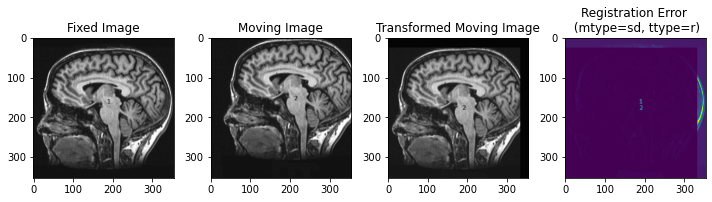


Registration took 6 sec.


In [5]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain2.png", "brain1.png", 'sd', 'r')
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

# Let's add some extra functionality to the framework

**TASK 1**: Add two new similarity metrics to the framework:

1.   Normalized cross-correlation (NCC)
2.   Normalized gradient correlation (NGC)

**Normalized Cross-Correlation (NCC)**

 When aligning or registering two images, NCC can be used as an optimization criterion to find the transformation that minimizes the dissimilarity between the images. The error can be quantified as the inverse of the NCC score (i.e., 1 - NCC), where lower values indicate better alignment.
 
 **Normalized gradient correlation (NGC)**

NGC is a numerical measure used to evaluate the quality of alignment between two images by considering their gradient information.
 The alignment error in this context can be quantified as the dissimilarity between the gradients of the two images. In this case we want to minime this value. 
 Error=1−Normalized Gradient Cross-Correlation


Here is the example code for both metrics:

In [ ]:
"""     mtype == 'ncc':
        mean_A = np.mean(I3)
        mean_B = np.mean(Ifixed)
        diff_meanA = I3 - mean_A
        diff_meanB = Ifixed - mean_B
        numerator = np.sum(diff_meanA*diff_meanB)
        denom_A = np.sum((diff_meanA)**2)
        denom_B = np.sum((diff_meanB)**2)
        mult = denom_A * denom_B
        e = 1 - numerator / np.sqrt( mult )
    mtype == 'ngc': 
        gx_fix = sobel(Ifixed, axis=0, mode='constant')
        gy_fix = sobel(Ifixed, axis=1, mode='constant')
        gx_reg = sobel(I3, axis=0, mode='constant')
        gy_reg = sobel(I3, axis=1, mode='constant')
        p = np.abs((gx_fix * gx_reg) + (gy_fix * gy_reg))
        e1 = gx_fix ** 2 + gy_fix ** 2
        e2 = gx_reg ** 2 + gy_reg ** 2
        e = 1 - np.sum(p) / np.sqrt(np.sum(e1) * np.sum(e2)) """

**TASK 2**: Modify the framework to be able to deal with full affine 2D transformations.
   - **QUESTION 4**: Justify how you initialize the transformation.

**Full Affine Transformation**

Full Affine Transformation is equal to multiply 4 matrices: 

- Translation Matrix (tx and ty are the parameters)
- Rotation Matrix  (theta is the angle to be rotated)
- Scaling Matrix (Sx and Sy are the scaling parameters)
- Shearing Matrix (Shearx and Sheary are the shearing parameters)

In this case we need 7 parameters in the x vector in order to construct our matrix. 

We set the parameters to 0 and the scaling parameter to 1. 

Here we can see the code added to implement the full affine: 


In [ ]:
#Full affine transformation
# Extract individual transformation components
tx, ty, theta, sx, sy, shear_x, shear_y = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
# Construct the full affine transformation matrix
M = np.array([[sx * np.cos(theta), -sy * np.sin(theta + shear_x), tx],
              [sx * np.sin(theta + shear_y), sy * np.cos(theta), ty],
              [0, 0, 1]])
        

*Your answer here*



**TASK 3**: Implement the above modifications in a multi-resolution registration framework. The number of resolutions should be a parameter of the framework.
  - **QUESTION 5**: Discuss how each resolution is initialized.
  - **QUESTION 6**: Justify the benefits of multi-resolution in terms of computation time and/or accuracy of the final result, compared to a single resolution.

**Multiresolution Registration Framework**

The resolution is initialize from the fist image, then we are going to build the resolution pyramid with the levels given in the function.

The time is faster, since with very complicated images you can start with values that are near the images one, in the other hand there is an increase in accuraccy in the case that you don't exceed the levels on which your local minimum exits.



# Let's try your implementation

**TASK 4**: Show some registration results using brain1.png, brain2.png, brain3.png, and brain4.png with the different combinations of the registration framework: different <u>metrics</u>, <u>transformations</u> and <u>multi-resolution levels</u>.



# 1. Rigid Transformation, ResolutionL: 1
**METRIC: SD**

Parameters: [-1.45304428e+01  1.64989237e+00  9.41721477e-04]
Error of Result: 5.51270%


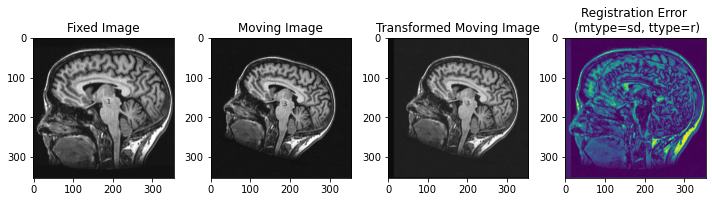


Registration took 1 sec.


In [12]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain3.png", "brain1.png", 'sd', 'r')
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [-9.24404428e+02  6.75050546e+01 -3.67713259e-03]
Error of Result: 13.15589%


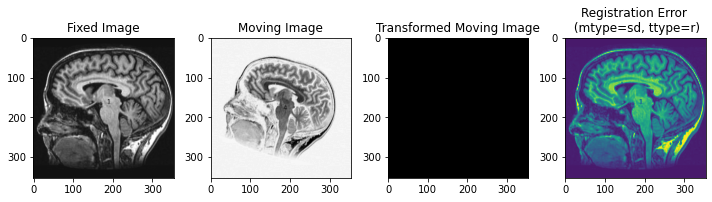


Registration took 3 sec.


In [11]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain4.png", "brain1.png", 'sd', 'r')
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

C:\Users\carme\AppData\Local\Temp\ipykernel_6636\2755192301.py:33: RuntimeWarning: invalid value encountered in scalar divide
  e = 1 - numerator / np.sqrt( mult )


Parameters: [ 2.19980351e+01 -2.39978758e+01 -2.97744016e-06]
Error of Result: 0.38701%


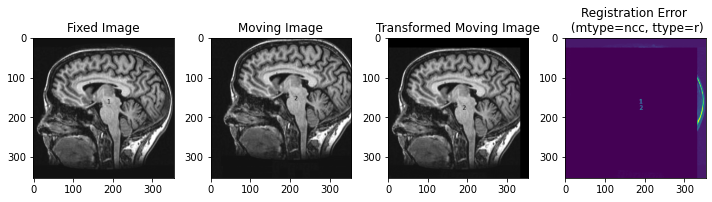


Registration took 4 sec.


In [8]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain2.png", "brain1.png", 'ncc', 'r')
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

**METRIC: NCC**

Parameters: [-11.23092914  -3.35161356  -0.33049915]
Error of Result: 5.36650%


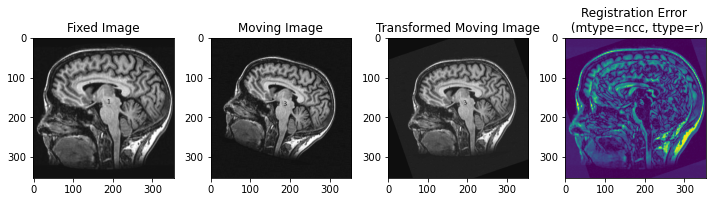


Registration took 10 sec.


In [9]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain3.png", "brain1.png", 'ncc', 'r')
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [-3.58761195e+00 -2.32835237e+01  1.47660872e-02]
Error of Result: 32.80011%


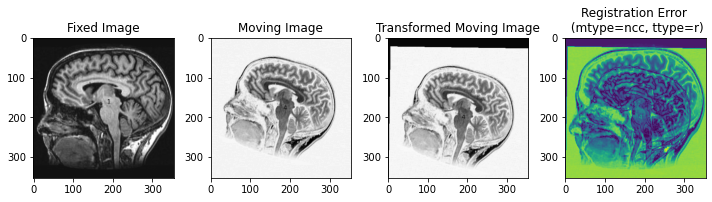


Registration took 3 sec.


In [10]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain4.png", "brain1.png", 'ncc', 'r')
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [0. 0. 0.]
Error of Result: 5.87440%


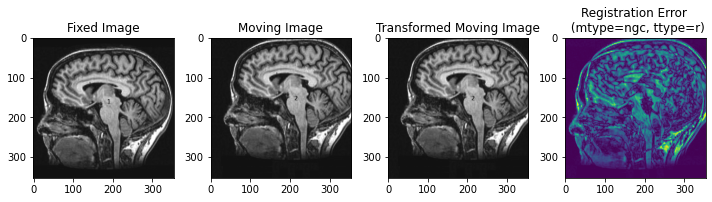


Registration took 1 sec.


In [13]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain2.png", "brain1.png", 'ngc', 'r')
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

**METRIC: NGC**

Parameters: [0. 0. 0.]
Error of Result: 5.79098%


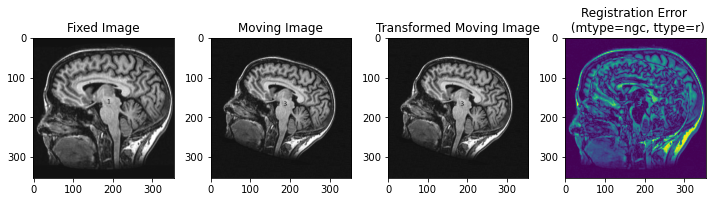


Registration took 1 sec.


In [14]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain3.png", "brain1.png", 'ngc', 'r')
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [0. 0. 0.]
Error of Result: 38.36309%


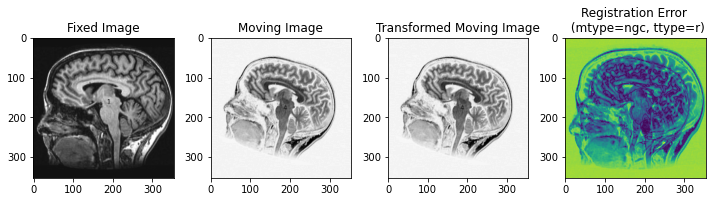


Registration took 1 sec.


In [15]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain4.png", "brain1.png", 'ngc', 'r')
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

# 2. Affine Transformation, ResolutionL: 1
**METRIC: SD**

Parameters: [ 0.11639445 -0.01892706 -0.07567796  1.11618677  1.09186232  0.01910605
 -0.11652706]
Error of Result: 4.87472%


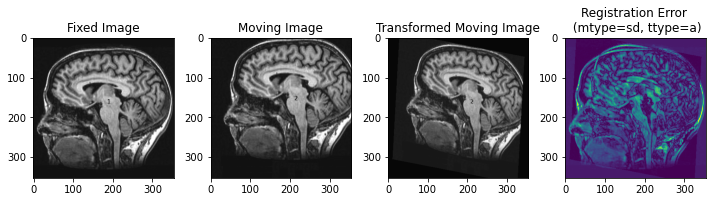


Registration took 9 sec.


In [16]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain2.png", "brain1.png", 'sd', 'a',np.array([1, 1, 1, 1, 1, 1, 1]))
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [-4.95275157 -3.7643828   0.83442617  1.1376491   1.13818405 -0.62466052
 -0.62509891]
Error of Result: 0.04234%


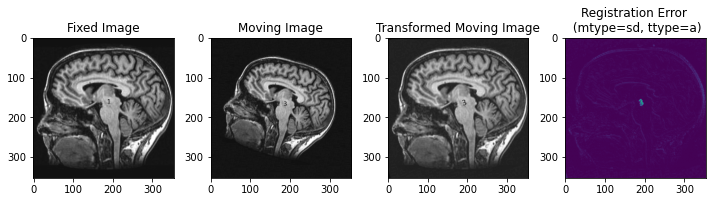


Registration took 13 sec.


In [17]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain3.png", "brain1.png", 'sd', 'a',np.array([1, 1, 1, 1, 1, 1, 1]))
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [0.20757441 0.20611296 0.75478241 2.22191477 2.01138891 0.56913031
 0.87230578]
Error of Result: 13.28717%


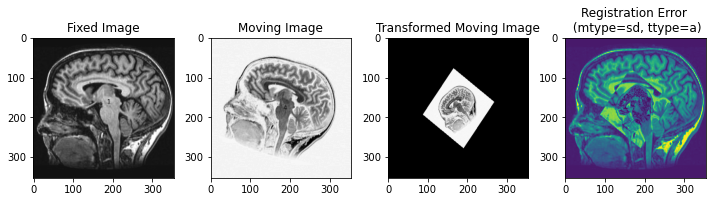


Registration took 4 sec.


In [18]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain4.png", "brain1.png", 'sd', 'a',np.array([1, 1, 1, 1, 1, 1, 1]))
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

**METRIC: NCC**

Parameters: [ 0.17483914  0.03662767 -0.00168701  1.14723758  1.20992879  0.12581151
 -0.13131221]
Error of Result: 4.97387%


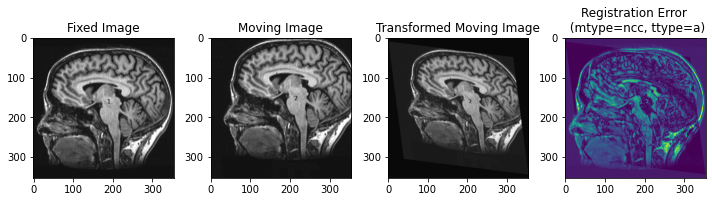


Registration took 5 sec.


In [19]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain2.png", "brain1.png", 'ncc', 'a',np.array([1, 1, 1, 1, 1, 1, 1]))
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [-4.470591   -4.06364672 -0.97170532  1.35353304  1.35726371  1.14007212
  1.14688958]
Error of Result: 0.22361%


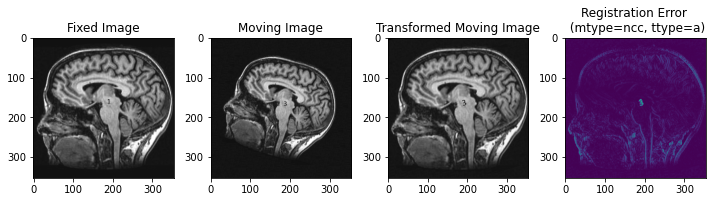


Registration took 19 sec.


In [20]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain3.png", "brain1.png", 'ncc', 'a',np.array([1, 1, 1, 1, 1, 1, 1]))
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [0.25218615 0.26233044 0.47922914 1.29464198 1.56966448 0.10774477
 0.42997519]
Error of Result: 14.83474%


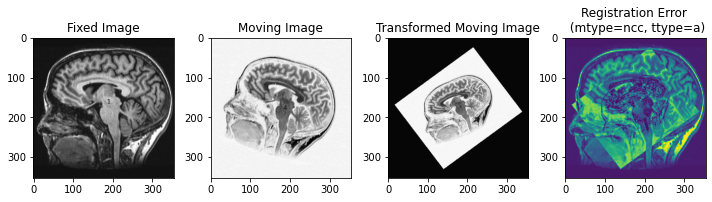


Registration took 6 sec.


In [21]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain4.png", "brain1.png", 'ncc', 'a',np.array([1, 1, 1, 1, 1, 1, 1]))
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

**METRIC: NGC**

Parameters: [-0.19541345 -0.01993515 -0.09828903  0.81698956  0.86985816 -0.07993259
 -0.02196545]
Error of Result: 6.78511%


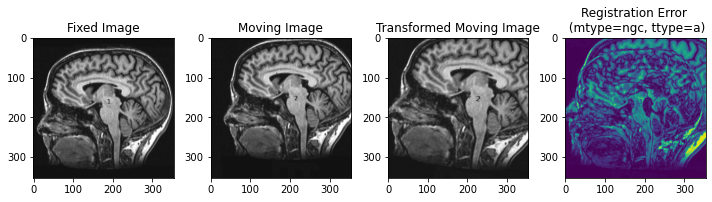


Registration took 5 sec.


In [22]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain2.png", "brain1.png", 'ngc', 'a',np.array([1, 1, 1, 1, 1, 1, 1]))
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [-0.0028694  -0.02820609  0.10637315  0.77375289  0.84154888  0.01774259
  0.06559695]
Error of Result: 3.36196%


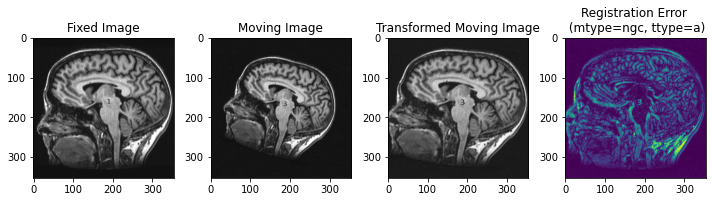


Registration took 10 sec.


In [23]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain3.png", "brain1.png", 'ngc', 'a',np.array([1, 1, 1, 1, 1, 1, 1]))
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [-0.07501267 -0.08913345  0.12590215  0.77370826  0.82025947 -0.00482025
  0.06093367]
Error of Result: 34.66822%


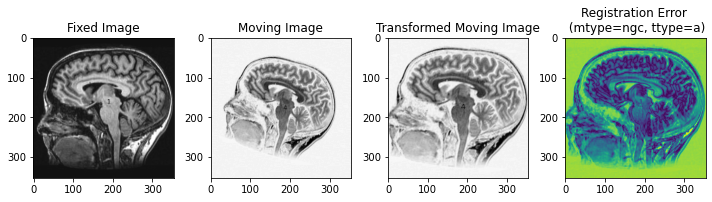


Registration took 10 sec.


In [24]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain4.png", "brain1.png", 'ngc', 'a',np.array([1, 1, 1, 1, 1, 1, 1]))
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

# 3. Rigid Transformation - MultiResolution
**METRIC: SD**

Parameters: [ 2.72341910e+00 -2.99053668e+00  4.56911224e-04]
Mean Squared Error Result: 5.66893%


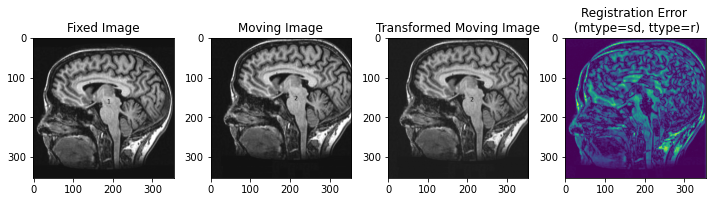


Registration took 12 sec.


In [71]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain2.png", "brain1.png", 'sd', 'r',num_levels=4,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [-0.47995532  0.07289013 -0.28383328]
Mean Squared Error Result: 5.63739%


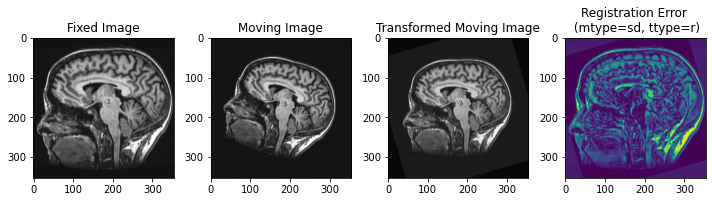


Registration took 9 sec.


In [72]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain3.png", "brain1.png", 'sd', 'r',num_levels=6,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [ 289.49601675 -175.32302763    0.69620408]
Mean Squared Error Result: 16.54180%


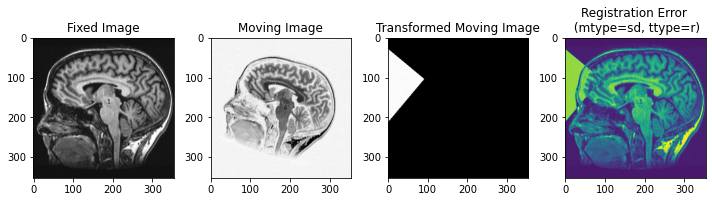


Registration took 7 sec.


In [73]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain4.png", "brain1.png", 'sd', 'r',num_levels=8,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

**METRIC: NCC**

Parameters: [ 1.09977674e+01 -1.19619084e+01 -2.63356592e-05]
Mean Squared Error Result: 4.73441%


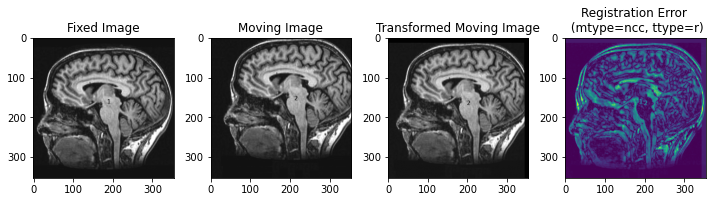


Registration took 9 sec.


In [88]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain2.png", "brain1.png", 'ncc', 'r',num_levels=3,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [-0.53912888  0.11149546 -0.3592545 ]
Mean Squared Error Result: 5.50768%


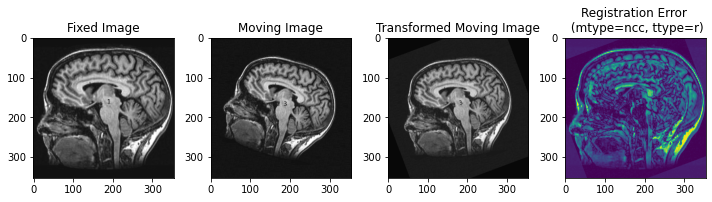


Registration took 8 sec.


In [74]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain3.png", "brain1.png", 'ncc', 'r',num_levels=6,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

C:\Users\carme\AppData\Local\Temp\ipykernel_6636\2755192301.py:33: RuntimeWarning: invalid value encountered in scalar divide
  e = 1 - numerator / np.sqrt( mult )


Parameters: [  9.51152736 -32.69277639  -0.76031746]
Mean Squared Error Result: 25.14087%


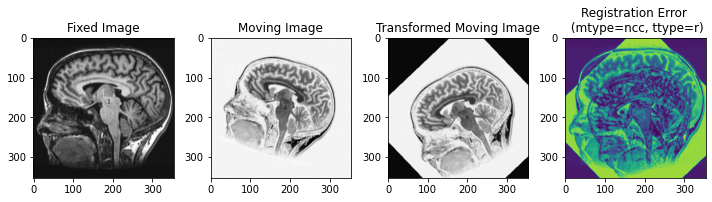


Registration took 11 sec.


In [75]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain4.png", "brain1.png", 'ncc', 'r',num_levels=7,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

**METRIC: NGC**

C:\Users\carme\AppData\Local\Temp\ipykernel_6636\2755192301.py:42: RuntimeWarning: invalid value encountered in scalar divide
  e = 1 - np.sum(p) / np.sqrt(np.sum(e1) * np.sum(e2))


Parameters: [-0.00504917 -0.00705728  0.00861551]
Mean Squared Error Result: 5.85045%


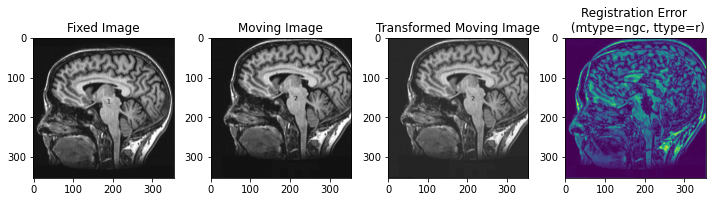


Registration took 4 sec.


In [76]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain2.png", "brain1.png", 'ngc', 'r',num_levels=8,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

C:\Users\carme\AppData\Local\Temp\ipykernel_6636\2755192301.py:42: RuntimeWarning: invalid value encountered in scalar divide
  e = 1 - np.sum(p) / np.sqrt(np.sum(e1) * np.sum(e2))


Parameters: [-0.3724769   0.17970525 -0.295425  ]
Mean Squared Error Result: 5.61584%


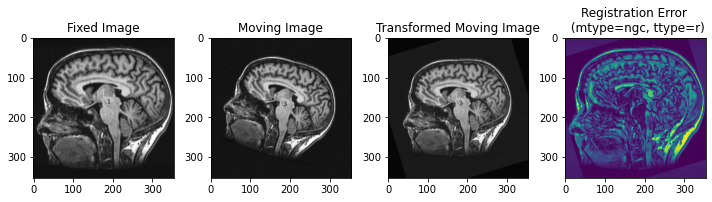


Registration took 5 sec.


In [77]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain3.png", "brain1.png", 'ngc', 'r',num_levels=8,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [ 0.76130479 -0.77619263 -0.14000341]
Mean Squared Error Result: 33.78648%


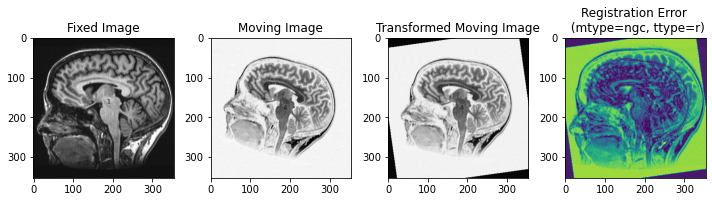


Registration took 4 sec.


In [78]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain4.png", "brain1.png", 'ngc', 'r',num_levels=8,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

# 3. Affine Transformation - MultiResolution
**METRIC: SD**

Parameters: [ 0.12131422 -0.02859308 -0.08436871  1.11424728  1.10712896  0.01733618
 -0.12679282]
Mean Squared Error Result: 4.95403%


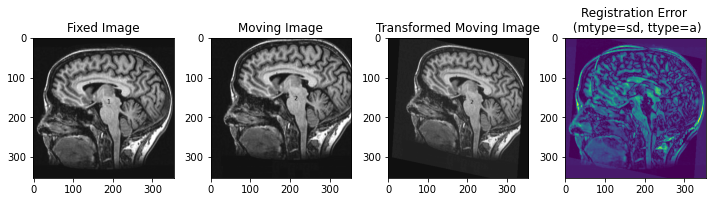


Registration took 17 sec.


In [79]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain2.png", "brain1.png",'sd','a',num_levels=4,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [-0.80372985 -0.49044718  0.41269546  0.833614    0.83338222 -0.1270581
 -0.12406421]
Mean Squared Error Result: 3.27741%


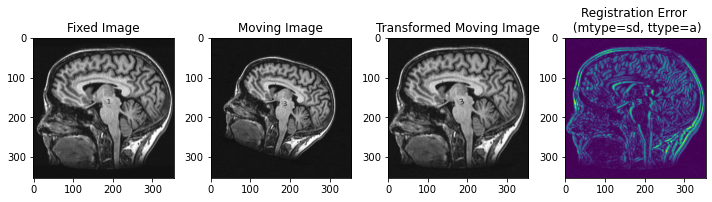


Registration took 28 sec.


In [80]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain3.png", "brain1.png", 'sd', 'a',num_levels=4,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [ 0.20911275  0.18652992 -0.31769118  2.68482458  2.31042815  1.97192673
  0.7423807 ]
Mean Squared Error Result: 12.64051%


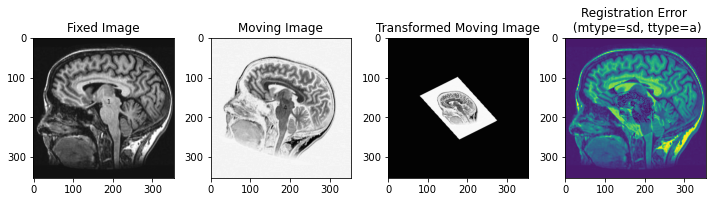


Registration took 10 sec.


In [81]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain4.png", "brain1.png", 'sd', 'a',num_levels=4,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

**METRIC: NCC**

C:\Users\carme\AppData\Local\Temp\ipykernel_6636\2755192301.py:33: RuntimeWarning: invalid value encountered in scalar divide
  e = 1 - numerator / np.sqrt( mult )


Parameters: [ 0.57555824 -0.68290718 -0.01337196  1.02256484  1.05755321 -0.01573599
 -0.0247727 ]
Mean Squared Error Result: 5.47258%


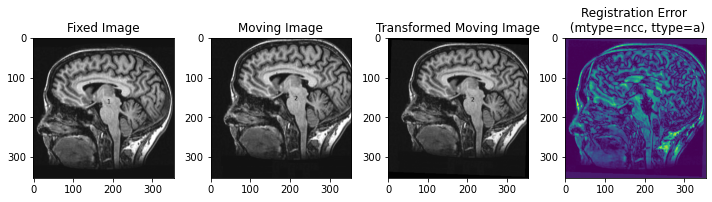


Registration took 12 sec.


In [82]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain2.png", "brain1.png",  'ncc', 'a',num_levels=6,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [-0.40805891 -0.08397159 -0.96979888  1.32863742  1.37500949  1.15224178
  1.12616688]
Mean Squared Error Result: 3.13014%


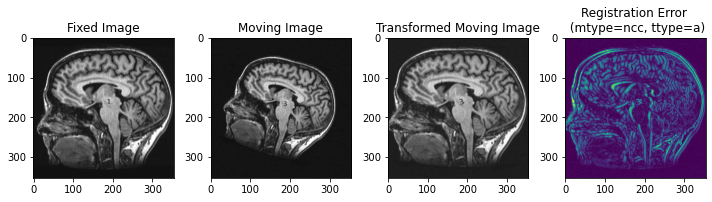


Registration took 83 sec.


In [83]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain3.png", "brain1.png",  'ncc', 'a',num_levels=6,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [0.33241367 0.22628485 0.53085414 1.3094288  1.69641177 0.09161781
 0.48784615]
Mean Squared Error Result: 14.20852%


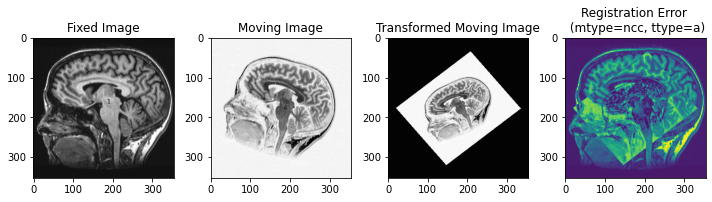


Registration took 29 sec.


In [84]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain4.png", "brain1.png",  'ncc', 'a',num_levels=6,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

**METRIC: NGC**

Parameters: [ 0.22558363 -0.48455955  0.02303658  0.92423798  1.10148999 -0.02126638
 -0.00908647]
Mean Squared Error Result: 5.77741%


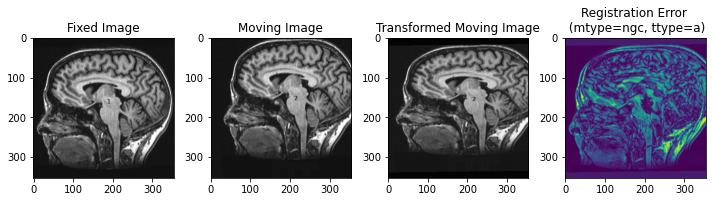


Registration took 37 sec.


In [85]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain2.png", "brain1.png",  'ngc', 'a',num_levels=6,MidResultsOn=False)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [-0.41281324 -0.11038883  0.22335873  0.77146248  0.7932718   0.07307882
  0.08587868]
Mean Squared Error Result: 3.23883%


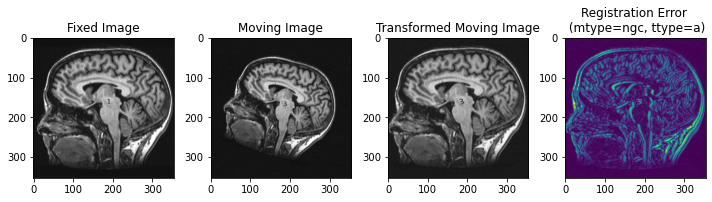


Registration took 50 sec.


In [86]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain3.png", "brain1.png",  'ngc', 'a',num_levels=6,MidResultsOn=False)
end = datetime.datetime.now()
print(f'\nRegistration took {(end-start).seconds} sec.')

Parameters: [-0.47188393 -0.27949823  0.23811398  0.81762776  0.80624624  0.09352331
  0.08128124]
Mean Squared Error Result: 35.65424%


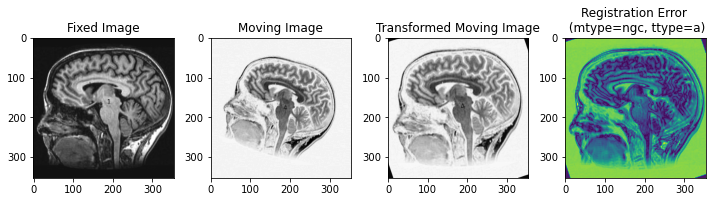


Registration took 54 sec.


In [87]:
start = datetime.datetime.now()
Iregistered, transformation_matrix = multi_resolution_affine_reg2D("brain4.png", "brain1.png",  'ngc', 'a',num_levels=6,MidResultsOn=False)
end = datetime.datetime.now()
print(f'\nRegistration took {(end-start).seconds} sec.')

**TASK 5**: For selected (representative) cases, plot the metric against iterations, computation time, registration results and final error (<u>propose a quantitative error measure</u>).

In [13]:
#Your code here




**QUESTION 7**: Are the results what you were expecting? If not, explain why.

In our experiments, we conducted various tests using different metrics for image registration, and the results aligned with our expectations. Here's a summary of what we observed:

**Affine vs. Rigid Transformation**:
- We anticipated that the optimizer would perform better with rigid transformations since they have fewer parameters to optimize compared to full affine transformations (which have 7 parameters). Our results confirmed this expectation.

**Multiresolution**:
- When we applied multiresolution techniques, we expected improvements in both affine and rigid transformations. This anticipation was based on the idea that using multiple resolutions of the same image would enhance the optimization of transformation parameters. However, we found that multiresolution wasn't particularly necessary for rigid transformations. In contrast, for full affine transformations, the results improved significantly when testing with multiple levels of resolution.

**Choice of Metrics**:
- We used different metrics to assess the performance of the optimizer, with a particular focus on the negative image case. In this scenario, we expected the Normalized Gradient Cross-Correlation Error (NGC) metric to outperform others. This expectation was based on the fact that NGC relies on gradients rather than pixel intensities, and should, in theory, handle inverted images effectively. Our visual results confirmed this expectation, as NGC consistently produced the best results in cases involving negative images.

In summary, our experiments provided insights into the effectiveness of different transformation types, multiresolution techniques, and metrics for image registration. The results supported our expectations, and we were able to draw valuable conclusions about which approaches and metrics worked best for specific scenarios, including handling inverted images.